# Moderation: Train your own moderation service

In this cookbook, we will explore classification for moderation using our Classifier Factory to build classifiers tailored to your specific needs and use cases.

To keep things straightforward, we will concentrate on a particular example that involves multilabel classification for content moderation.

## Dataset
We will use a subset of the [google/civil_comments](https://huggingface.co/datasets/google/civil_comments) dataset. This subset includes several labels that we will for multi-label classification, allowing us to obtain scores for each type of moderation.

### Subset
Lets download and prepare the subset, we will install `datasets` and load it.

In [ ]:
%%capture
!pip install datasets

In [ ]:
# @title Loading subset
%%capture
from datasets import load_dataset
import pandas as pd
import random

# Load the civil_comments dataset with streaming
dataset = load_dataset("google/civil_comments", streaming=True)

# Select only a subset
n_train = 1_000_000
n_validation = 50_000
n_test = 50_000


# Function to convert scores to booleans depending on a threshold
def convert_scores_to_booleans(example, threshold=0.5):
    return {
        "text": example["text"],
        "toxicity": example["toxicity"] > threshold,
        "severe_toxicity": example["severe_toxicity"] > threshold,
        "obscene": example["obscene"] > threshold,
        "threat": example["threat"] > threshold,
        "insult": example["insult"] > threshold,
        "identity_attack": example["identity_attack"] > threshold,
        "sexual_explicit": example["sexual_explicit"] > threshold,
    }


# Shuffle, take, and convert the dataset splits
train_samples = [
    convert_scores_to_booleans(example)
    for example in dataset["train"].shuffle(seed=42, buffer_size=n_train).take(n_train)
]
validation_samples = [
    convert_scores_to_booleans(example)
    for example in dataset["validation"]
    .shuffle(seed=42, buffer_size=n_validation)
    .take(n_validation)
]
test_samples = [
    convert_scores_to_booleans(example)
    for example in dataset["test"].shuffle(seed=42, buffer_size=n_test).take(n_test)
]


# Naive filter that removes 90% of samples with zero flags and next ensures each label represents max 20% of total flagged samples
def filter_dataset(samples, zero_flags_percentage=0.1, max_percentage=0.2):
    zero_flags_samples = []
    non_zero_flags_samples = []
    label_counts = {key: 0 for key in samples[0] if key != "text"}

    for example in samples:
        if not any(
            example[key] for key in example if key != "text"
        ):  # Check if all flags are False
            zero_flags_samples.append(example)
        else:
            non_zero_flags_samples.append(example)

    # Calculate the total number of samples needed
    total_samples = len(non_zero_flags_samples) / (1 - zero_flags_percentage)

    # Calculate the number of zero-flag samples needed
    desired_zero_flags = int(total_samples * zero_flags_percentage)
    desired_non_zero_flags = int(total_samples * (1 - zero_flags_percentage))

    # Keep only the desired number of zero-flag and non-zero-flag samples
    zero_flags_samples = zero_flags_samples[:desired_zero_flags]
    filtered_samples = []

    for example in non_zero_flags_samples[:desired_non_zero_flags]:
        # Check if adding this example exceeds the max percentage for any label
        add_sample = True
        for key in label_counts:
            if example[key]:
                if (label_counts[key] + 1) / desired_non_zero_flags > max_percentage:
                    add_sample = False
                    break

        if add_sample:
            filtered_samples.append(example)
            for key in label_counts:
                if example[key]:
                    label_counts[key] += 1

    # Combine the filtered zero-flag samples with the non-zero-flag samples
    filtered_samples += zero_flags_samples

    # Shuffle the filtered samples
    random.shuffle(filtered_samples)

    return filtered_samples


# Filter the samples
train_samples = filter_dataset(train_samples)
validation_samples = filter_dataset(validation_samples)
test_samples = filter_dataset(test_samples)

# Combine all samples to calculate label percentages
all_samples = train_samples + validation_samples + test_samples
all_df = pd.DataFrame(all_samples)

# Calculate the percentage of samples for each label
label_percentages = all_df.drop(columns=["text"]).mean()

# Identify labels with less than 1% samples
labels_to_remove = label_percentages[label_percentages < 0.01].index.tolist()

# Remove the identified labels from all splits
train_df = pd.DataFrame(train_samples).drop(columns=labels_to_remove)
validation_df = pd.DataFrame(validation_samples).drop(columns=labels_to_remove)
test_df = pd.DataFrame(test_samples).drop(columns=labels_to_remove)

In [ ]:
# Print the length of samples for each set
print("Train set length:", len(train_df))
print("Validation set length:", len(validation_df))
print("Test set length:", len(test_df))

# Display the test DataFrame to verify
test_df

Train set length: 20607
Validation set length: 1010
Test set length: 1013


,text,toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,Flim flam artist Paul Ryan doing his stuff....,False,False,False,False,False,False
1,The current winner-take-all method of awarding...,False,False,False,False,False,False
2,I guess you'll have to decrease your consumpti...,False,False,False,False,False,False
3,Raps are toast. Zero character. Zero class. ...,True,False,False,True,False,False
4,"Something is wrong, the wife was shouting he h...",False,False,False,False,False,False
...,...,...,...,...,...,...,...
1008,"""Justin Trudeau to stand up to Donald Trump""?\...",True,False,False,True,False,False
1009,There's little doubt that Donald Trump is a di...,False,False,False,False,False,False
1010,racism. Gotta undo what the black man built!,True,False,False,False,True,False
1011,He didn't lash out at Gold Star families. That...,True,False,False,True,False,False


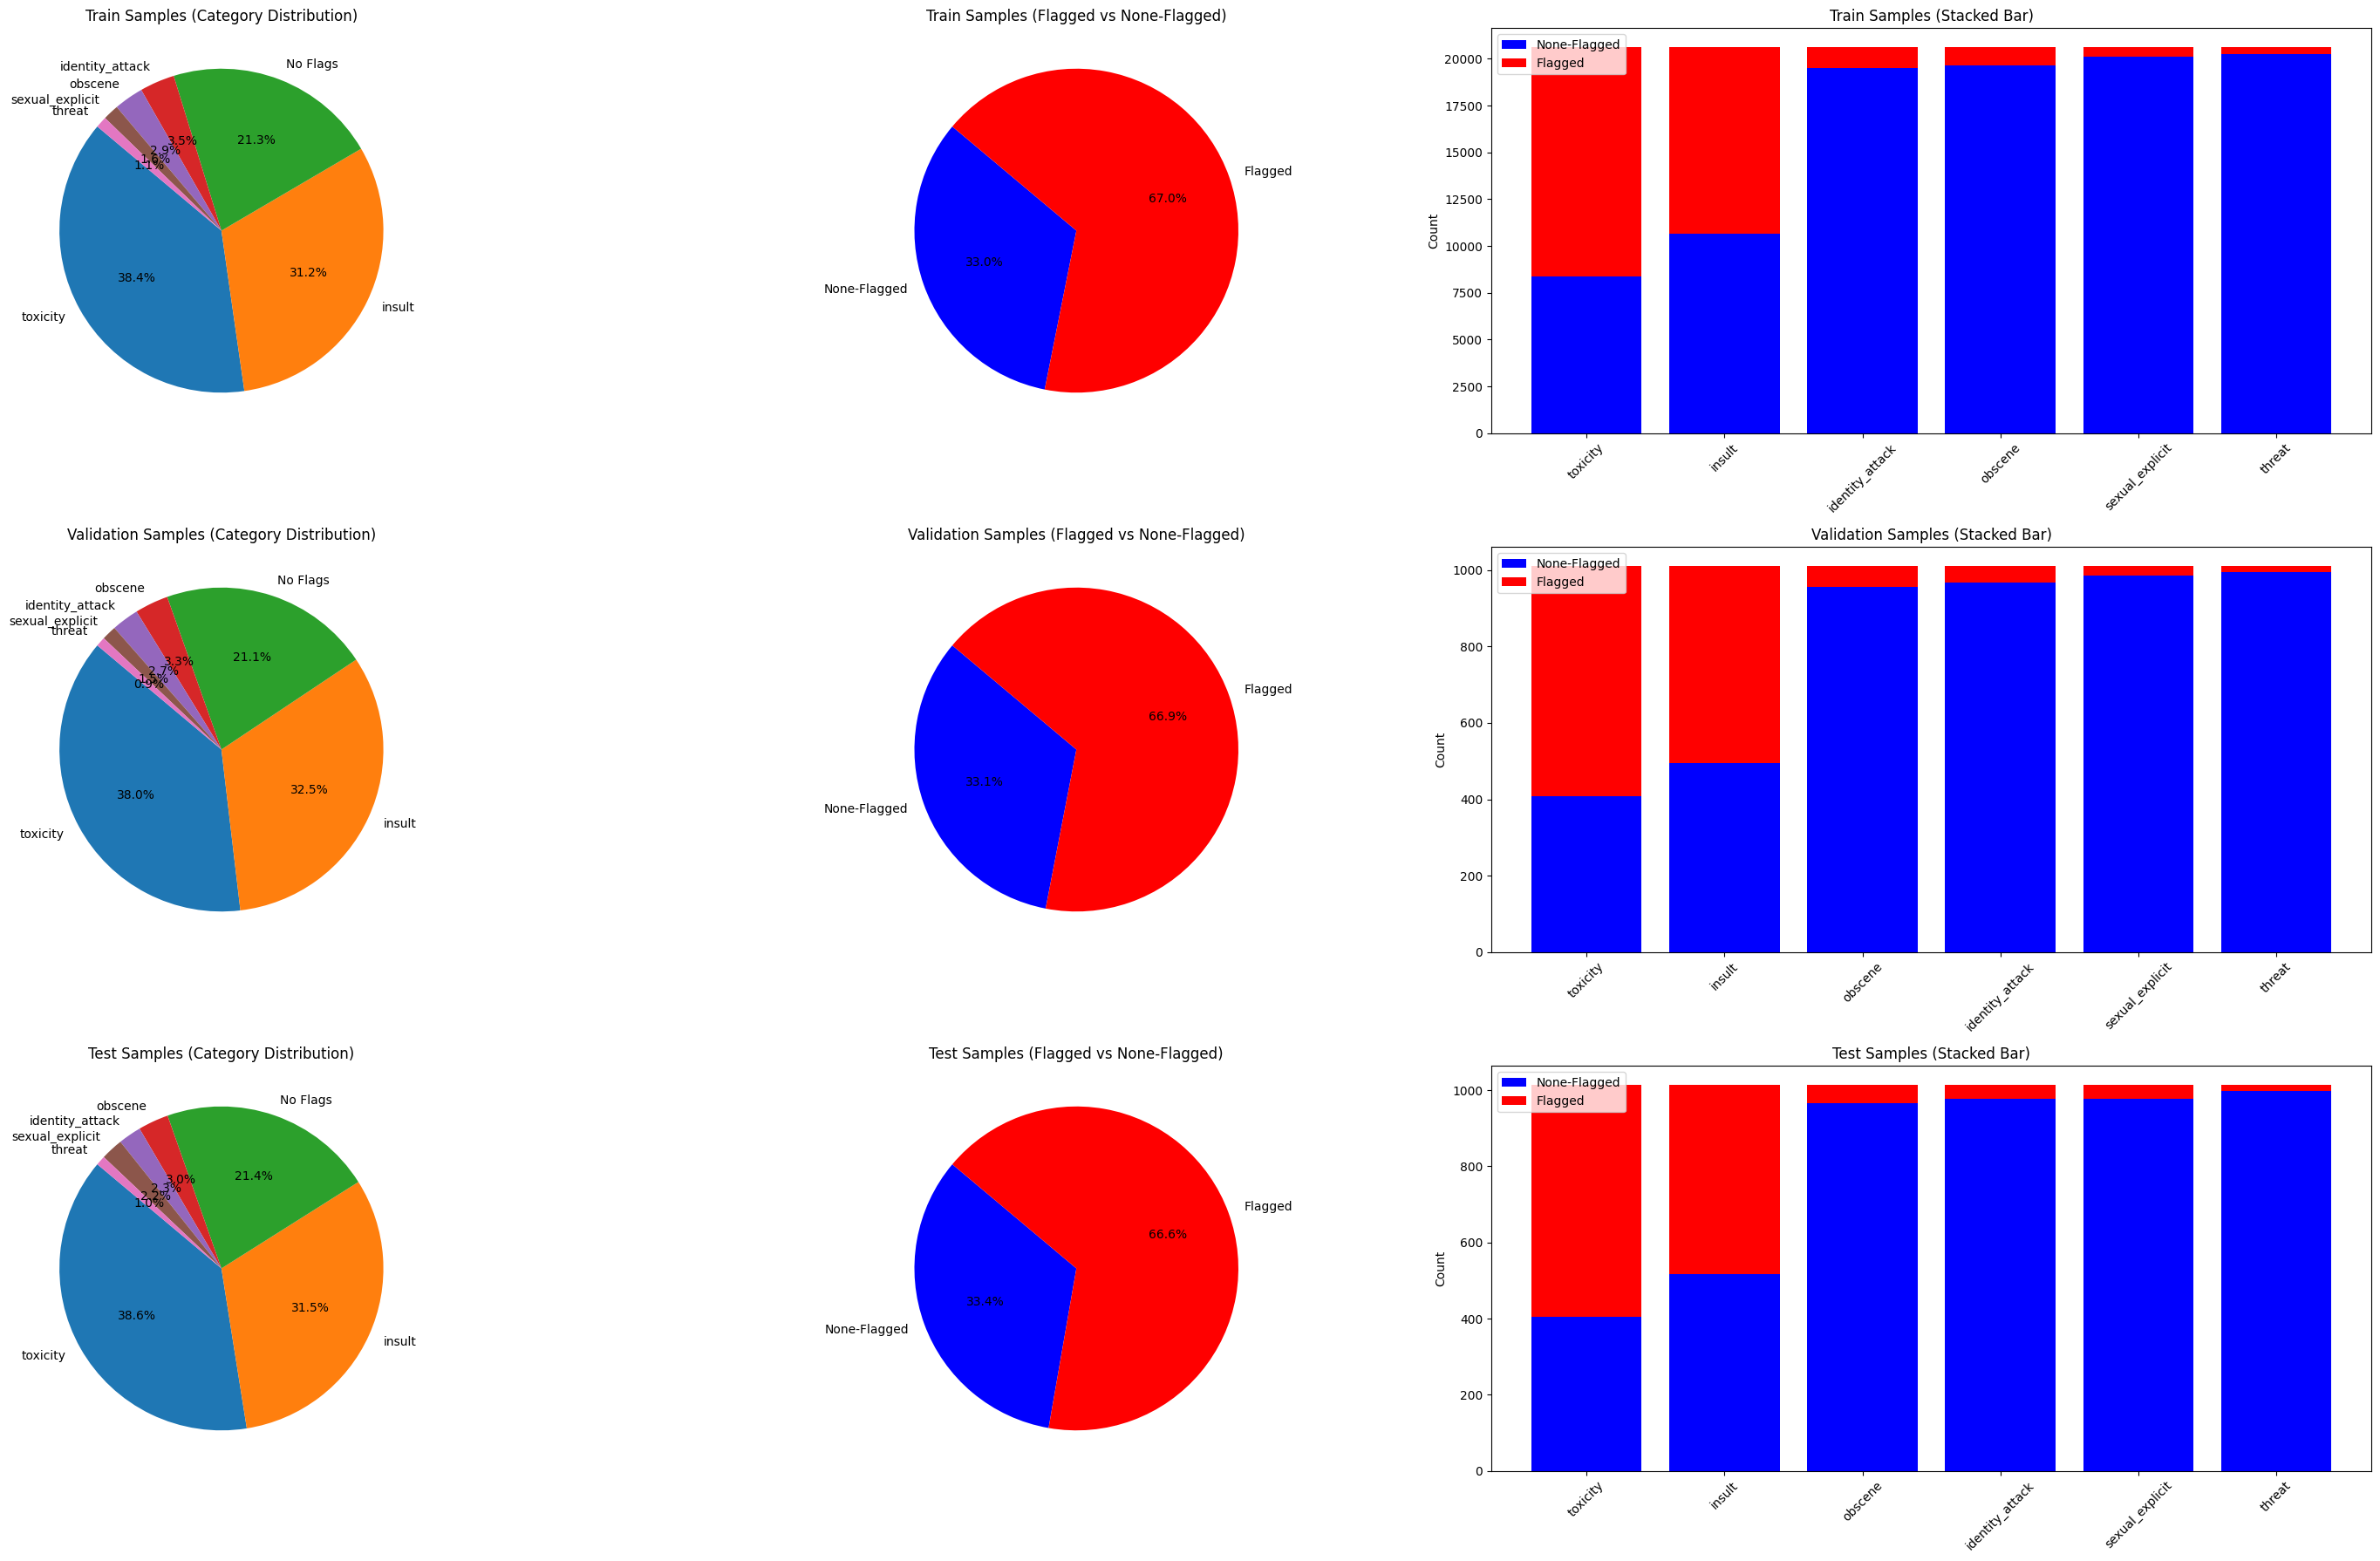

In [ ]:
# @title Displaying distribution
import matplotlib.pyplot as plt
from collections import defaultdict


# Function to count the number of samples flagged for each category
def count_flags(samples, labels_to_keep):
    no_flags = sum(
        all(
            value == False
            for key, value in sample.items()
            if key != "text" and key in labels_to_keep
        )
        for sample in samples
    )
    counts = {key: sum(sample[key] for sample in samples) for key in labels_to_keep}
    return [no_flags] + list(counts.values())


# Function to count flagged and non-flagged samples for each label
def count_flagged_vs_non_flagged(samples, labels_to_keep):
    counts = defaultdict(lambda: {"flagged": 0, "none-flagged": 0})
    for sample in samples:
        for key, value in sample.items():
            if key != "text" and key in labels_to_keep:
                if value:
                    counts[key]["flagged"] += 1
                else:
                    counts[key]["none-flagged"] += 1
    return counts


# Function to count total flagged and non-flagged samples
def count_total_flagged_vs_non_flagged(samples, labels_to_keep):
    total_flagged = 0
    total_non_flagged = 0
    for sample in samples:
        flagged = any(
            value
            for key, value in sample.items()
            if key != "text" and key in labels_to_keep
        )
        if flagged:
            total_flagged += 1
        else:
            total_non_flagged += 1
    return [total_non_flagged, total_flagged]


# Create a list of labels for the pie charts from the samples
labels_to_keep = [
    key for key in train_samples[0] if key != "text" and key not in labels_to_remove
]
labels = ["No Flags"] + labels_to_keep

# Count flags for each dataset
train_counts = count_flags(train_samples, labels_to_keep)
validation_counts = count_flags(validation_samples, labels_to_keep)
test_counts = count_flags(test_samples, labels_to_keep)

# Count total flagged vs non-flagged for each dataset
total_train_counts = count_total_flagged_vs_non_flagged(train_samples, labels_to_keep)
total_validation_counts = count_total_flagged_vs_non_flagged(
    validation_samples, labels_to_keep
)
total_test_counts = count_total_flagged_vs_non_flagged(test_samples, labels_to_keep)

# Sort the labels and counts for pie charts
sorted_train_labels, sorted_train_counts = zip(
    *sorted(zip(labels, train_counts), key=lambda x: x[1], reverse=True)
)
sorted_validation_labels, sorted_validation_counts = zip(
    *sorted(zip(labels, validation_counts), key=lambda x: x[1], reverse=True)
)
sorted_test_labels, sorted_test_counts = zip(
    *sorted(zip(labels, test_counts), key=lambda x: x[1], reverse=True)
)

# Create a single figure with subplots for pie charts and stacked bar plots
fig, axes = plt.subplots(3, 3, figsize=(30, 18))

# Plot the pie charts for category distribution
axes[0, 0].pie(
    sorted_train_counts, labels=sorted_train_labels, autopct="%1.1f%%", startangle=140
)
axes[0, 0].set_title("Train Samples (Category Distribution)")

axes[1, 0].pie(
    sorted_validation_counts,
    labels=sorted_validation_labels,
    autopct="%1.1f%%",
    startangle=140,
)
axes[1, 0].set_title("Validation Samples (Category Distribution)")

axes[2, 0].pie(
    sorted_test_counts, labels=sorted_test_labels, autopct="%1.1f%%", startangle=140
)
axes[2, 0].set_title("Test Samples (Category Distribution)")

# Plot the pie charts for flagged vs non-flagged distribution
axes[0, 1].pie(
    total_train_counts,
    labels=["None-Flagged", "Flagged"],
    autopct="%1.1f%%",
    startangle=140,
    colors=["blue", "red"],
)
axes[0, 1].set_title("Train Samples (Flagged vs None-Flagged)")

axes[1, 1].pie(
    total_validation_counts,
    labels=["None-Flagged", "Flagged"],
    autopct="%1.1f%%",
    startangle=140,
    colors=["blue", "red"],
)
axes[1, 1].set_title("Validation Samples (Flagged vs None-Flagged)")

axes[2, 1].pie(
    total_test_counts,
    labels=["None-Flagged", "Flagged"],
    autopct="%1.1f%%",
    startangle=140,
    colors=["blue", "red"],
)
axes[2, 1].set_title("Test Samples (Flagged vs None-Flagged)")


# Create stacked bar plots for flagged vs. non-flagged samples
def plot_stacked_bar(ax, samples, title, labels_to_keep):
    counts = count_flagged_vs_non_flagged(samples, labels_to_keep)
    labels = counts.keys()
    flagged_counts = [counts[label]["flagged"] for label in labels]
    non_flagged_counts = [counts[label]["none-flagged"] for label in labels]

    # Sort the labels and counts for stacked bar plots by flagged counts
    sorted_labels, sorted_non_flagged_counts, sorted_flagged_counts = zip(
        *sorted(
            zip(labels, non_flagged_counts, flagged_counts),
            key=lambda x: x[2],
            reverse=True,
        )
    )

    ax.bar(sorted_labels, sorted_non_flagged_counts, label="None-Flagged", color="blue")
    ax.bar(
        sorted_labels,
        sorted_flagged_counts,
        bottom=sorted_non_flagged_counts,
        label="Flagged",
        color="red",
    )

    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.legend()
    ax.tick_params(axis="x", rotation=45)


# Plot stacked bar plots for each dataset
plot_stacked_bar(
    axes[0, 2], train_samples, "Train Samples (Stacked Bar)", labels_to_keep
)
plot_stacked_bar(
    axes[1, 2], validation_samples, "Validation Samples (Stacked Bar)", labels_to_keep
)
plot_stacked_bar(axes[2, 2], test_samples, "Test Samples (Stacked Bar)", labels_to_keep)

plt.tight_layout()
plt.show()

This will be the subset we will be training with. In an optimal scenario, you may need to do further curation and data preparation to balance the dataset and achieve better results. In this scenario, we have a fairly balanced dataset for `toxicity` and `insult`, but it is much less balanced for the rest of the labels.

## Format Data

Now that we have loaded our dataset, we will convert it to the proper desired format to upload for training.

The data will be converted to a **JSONL** format as follows:
```json
{"text": "I believe the Trump administration made a big mistake by its strict definition of family members allowed to visit the U.S. from the six Muslim-majority countries.   It knew or should have known opponents would pounce on a narrow definition and, therefore, should have expanded it a bit to deflect challenges and have a better chance of overcoming inevitable appeals in court.  Moreover, the relatives to be allowed in were not coming as permanent residents; they were coming as visitors for no longer than 6 months with a B1/B2 tourist visas.  Why fall on your sword over that?  Those coming to visit still had to be vetted by consular officials issuing tourist visas.  It would have been easy for the State Department to quietly tighten or enhance the vetting process in the six countries to make it a bit more difficult for people to obtain visas, thus minimizing the number of people coming and make it a non-issue.", "labels": {"moderation": ["safe"]}}
{"text": "Great comment Jake..", "labels": {"moderation": ["safe"]}}
{"text": "Uh huh. Then why don't you behave that way in the ADN comments section? \nYour alleged \"c'est la vie\" attitude is nowhere to be found on this website. Where's your vaunted \"personal integrity\" here?  You sound like Trump at his ridiculous and incredibly embarrassing - for him and his cabinet - \"Tell Me How Much You Worship Me\" fake cabinet meeting.", "labels": {"moderation": ["toxicity", "insult"]}}
{"text": "And given at least a two year probation, complete with random UAs and mandated counseling for liars.", "labels": {"moderation": ["toxicity", "insult"]}}
{"text": "You did make an accusation else there wouldn't be an investigation.", "labels": {"moderation": ["safe"]}}
...
```
With an example of a label being:
```json
"labels": {
  "moderation": [
    "toxicity",
    "insult"
  ]
}
```
For multi-label classification, we arbitrarily defined a new label "safe" to represent samples that were not flagged.

In [ ]:
from tqdm import tqdm
import json

def dataset_to_jsonl(dataset, output_file):
    # Extract the possible categories from the dataset columns, excluding the 'text' column
    possible_categories = [col for col in dataset.columns if col != "text"]

    # Open the output file in write mode
    with open(output_file, "w") as f:
        # Iterate over each row in the dataset
        for _, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
            # Extract the text and labels from the row
            text = row["text"]
            labels = [
                category
                for category in possible_categories
                if row[category]
            ]
            if len(labels) == 0:
                labels = ["safe"]

            # Create the JSON object
            json_object = {"text": text, "labels": {"moderation": labels}}

            # Write the JSON object to the file as a JSON line
            f.write(json.dumps(json_object) + "\n")

# Save files
dataset_to_jsonl(train_df, "training_file.jsonl")
dataset_to_jsonl(validation_df, "validation_file.jsonl")
dataset_to_jsonl(test_df, "test_file.jsonl")

100%|██████████| 1013/1013 [00:00<00:00, 51337.93it/s]


The data was converted and saved properly. We can now train our model.

## Training
There are two methods to train the model: either upload and train via [la platforme](https://console.mistral.ai/build/finetuned-models) or via the [API](https://classifier-factory.platform-docs-9m1.pages.dev/capabilities/finetuning/classifier_factory/).

First, we need to install `mistralai`.

In [ ]:
%%capture
!pip install mistralai

And setup our client, you can create an API key [here](https://console.mistral.ai/api-keys/).

In [ ]:
from mistralai import Mistral
import os

# Set the API key for Mistral
api_key = "API_KEY"
# Set your Weights and Biases key
# wandb_key = "WANDB_KEY"

# Initialize the Mistral client
client = Mistral(api_key=api_key)

We will upload 2 files, the training set and the validation set ( optional ) that will be used for validation loss.

In [ ]:
# Upload the training data
training_data = client.files.upload(
    file={
        "file_name": "training_file.jsonl",
        "content": open("training_file.jsonl", "rb"),
    }
)

# Upload the validation data
validation_data = client.files.upload(
    file={
        "file_name": "validation_file.jsonl",
        "content": open("validation_file.jsonl", "rb"),
    }
)

With the data uploaded, we can create a job.

In [ ]:
# Create a fine-tuning job
created_job = client.fine_tuning.jobs.create(
    model="ministral-3b-latest",
    job_type="classifier",
    training_files=[{"file_id": training_data.id, "weight": 1}],
    validation_files=[validation_data.id],
    hyperparameters={"training_steps": 200, "learning_rate": 0.00005},
    auto_start=False,
#   integrations=[
#       {
#           "project": "moderation-classifier",
#           "api_key": wandb_key,
#       }
#   ]
)
print(json.dumps(created_job.model_dump(), indent=4))

{
    "id": "cbe076ac-40a6-4fa4-9162-281531405d20",
    "auto_start": false,
    "model": "ministral-3b-latest",
    "status": "QUEUED",
    "created_at": 1744806685,
    "modified_at": 1744806685,
    "training_files": [
        "d0a8d6ac-2d9c-4d43-af04-e40b244fbdb3"
    ],
    "hyperparameters": {
        "training_steps": 200,
        "learning_rate": 5e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": null,
        "seq_len": 16384
    },
    "validation_files": [
        "ea6c9ca7-470b-4953-92ab-4f216a967852"
    ],
    "fine_tuned_model": null,
    "suffix": null,
    "integrations": [
        {
            "project": "moderation-classifier",
            "name": null,
            "run_name": null,
            "url": null
        }
    ],
    "trained_tokens": null,
    "metadata": {
        "expected_duration_seconds": null,
        "cost": 0.0,
        "cost_currency": null,
        "train_tokens_per_step": null,
        "train_tokens": null,
 

Once the job is created, we can review details such as the number of epochs and other relevant information. This allows us to make informed decisions before initiating the job.

We'll retrieve the job and wait for it to complete the validation process before starting. This validation step ensures the job is ready to begin.

In [ ]:
# Retrieve the job details
retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)
print(json.dumps(retrieved_job.model_dump(), indent=4))

import time
from IPython.display import clear_output

# Wait for the job to be validated
while retrieved_job.status not in ["VALIDATED"]:
    retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)

    clear_output(wait=True)  # Clear the previous output (User Friendly)
    print(json.dumps(retrieved_job.model_dump(), indent=4))
    time.sleep(1)

{
    "id": "cbe076ac-40a6-4fa4-9162-281531405d20",
    "auto_start": false,
    "model": "ministral-3b-latest",
    "status": "VALIDATED",
    "created_at": 1744806685,
    "modified_at": 1744806687,
    "training_files": [
        "d0a8d6ac-2d9c-4d43-af04-e40b244fbdb3"
    ],
    "hyperparameters": {
        "training_steps": 200,
        "learning_rate": 5e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": 7.29886929671425,
        "seq_len": 16384
    },
    "classifier_targets": [
        {
            "name": "moderation",
            "labels": [
                "toxicity",
                "safe",
                "identity_attack",
                "sexual_explicit",
                "obscene",
                "insult",
                "threat"
            ]
        }
    ],
    "validation_files": [
        "ea6c9ca7-470b-4953-92ab-4f216a967852"
    ],
    "fine_tuned_model": null,
    "suffix": null,
    "integrations": [
        {
            "p

We can now run the job.

In [ ]:
# Start the fine-tuning job
client.fine_tuning.jobs.start(job_id=created_job.id)

# Retrieve the job details again
retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)
print(json.dumps(retrieved_job.model_dump(), indent=4))

{
    "id": "cbe076ac-40a6-4fa4-9162-281531405d20",
    "auto_start": false,
    "model": "ministral-3b-latest",
    "status": "QUEUED",
    "created_at": 1744806685,
    "modified_at": 1744806690,
    "training_files": [
        "d0a8d6ac-2d9c-4d43-af04-e40b244fbdb3"
    ],
    "hyperparameters": {
        "training_steps": 200,
        "learning_rate": 5e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": 7.29886929671425,
        "seq_len": 16384
    },
    "classifier_targets": [
        {
            "name": "moderation",
            "labels": [
                "toxicity",
                "safe",
                "identity_attack",
                "sexual_explicit",
                "obscene",
                "insult",
                "threat"
            ]
        }
    ],
    "validation_files": [
        "ea6c9ca7-470b-4953-92ab-4f216a967852"
    ],
    "fine_tuned_model": null,
    "suffix": null,
    "integrations": [
        {
            "proj

The job is now starting. Let's keep track of the status and plot the loss.

For that, we highly recommend making use of our Weights and Biases integration, but we will also keep track of it directly in this notebook.

### WANDB

**Training:**

![moderation-train-loss.png](https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/classifier_factory/moderation-train-loss.png)

**Eval/Validation:**

![moderation-validation-loss.png](https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/classifier_factory/moderation-validation-loss.png)


SUCCESS


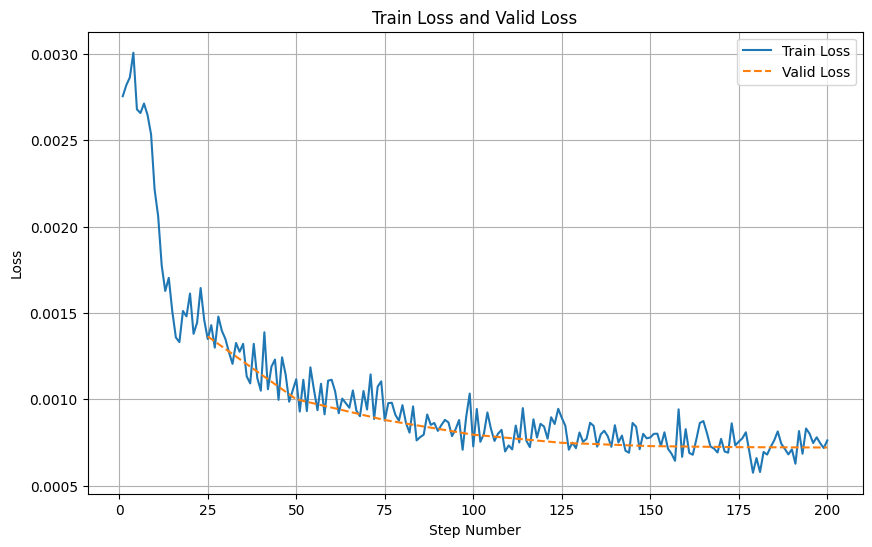

In [ ]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Initialize DataFrames to store the metrics
train_metrics_df = pd.DataFrame(columns=["Step Number", "Train Loss"])
valid_metrics_df = pd.DataFrame(columns=["Step Number", "Valid Loss"])

# Total training steps
total_training_steps = retrieved_job.hyperparameters.training_steps

# Wait for the job to complete
while retrieved_job.status in ["QUEUED", "RUNNING"]:
    retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)

    if retrieved_job.status == "QUEUED":
        time.sleep(5)
        continue

    # Clear the previous output (User Friendly)
    clear_output(wait=True)
    print(retrieved_job.status)

    # Extract metrics from all checkpoints
    for checkpoint in retrieved_job.checkpoints[::-1]:
        metrics = checkpoint.metrics
        step_number = checkpoint.step_number

        # Check if the step number is already in the DataFrame
        if (
            step_number
            not in train_metrics_df["Step Number"]
        ):
            # Prepare the new row for train loss
            train_row = {
                "Step Number": step_number,
                "Train Loss": metrics.train_loss,
            }

            # Append the new train metrics to the DataFrame
            train_metrics_df = pd.concat(
                [train_metrics_df, pd.DataFrame([train_row])], ignore_index=True
            )

            # Prepare the new row for valid loss if available
            if metrics.valid_loss != 0:
                valid_row = {
                    "Step Number": step_number,
                    "Valid Loss": metrics.valid_loss,
                }
                # Append the new valid metrics to the DataFrame
                valid_metrics_df = pd.concat(
                    [valid_metrics_df, pd.DataFrame([valid_row])], ignore_index=True
                )

    if len(retrieved_job.checkpoints) > 0:
        # Sort the DataFrames by step number
        train_metrics_df = train_metrics_df.sort_values(by="Step Number")
        valid_metrics_df = valid_metrics_df.sort_values(by="Step Number")

        # Plot the evolution of train loss and valid loss
        plt.figure(figsize=(10, 6))

        # Plot train loss
        plt.plot(
            train_metrics_df["Step Number"],
            train_metrics_df["Train Loss"],
            label="Train Loss",
            linestyle="-",
        )

        # Plot valid loss only if available
        if not valid_metrics_df.empty:
            plt.plot(
                valid_metrics_df["Step Number"],
                valid_metrics_df["Valid Loss"],
                label="Valid Loss",
                linestyle="--",
            )

        plt.xlabel("Step Number")
        plt.ylabel("Loss")
        plt.title("Train Loss and Valid Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    time.sleep(1)

### Inference
Our model is trained and ready for use! Let's test it on a sample from our test set!

In [ ]:
# Load the test samples
with open("test_file.jsonl", "r") as f:
    test_samples = [json.loads(l) for l in f.readlines()]

# Classify the first test sample
classifier_response = client.classifiers.classify(
    model=retrieved_job.fine_tuned_model,
    inputs=[test_samples[0]["text"]],
)
print("Text:", test_samples[0]["text"])
print("Classifier Response:", json.dumps(classifier_response.model_dump(), indent=4))

Text: Flim flam artist Paul Ryan doing his stuff....
Classifier Response: {
    "id": "9c3a76bc84204dcdadaf11e291365a3b",
    "model": "ft:classifier:ministral-3b-latest:8e2706f0:20250416:cbe076ac",
    "results": [
        {
            "moderation": {
                "scores": {
                    "toxicity": 0.11157931387424469,
                    "safe": 0.7990996837615967,
                    "identity_attack": 0.0010769261280074716,
                    "sexual_explicit": 0.0030203138012439013,
                    "obscene": 0.008739566430449486,
                    "insult": 0.07260604947805405,
                    "threat": 0.0038781599141657352
                }
            }
        }
    ]
}


For a more in-depth guide on multi-target, with an evaluation comparison between LLMs and our classifier API, visit this [cookbook](https://colab.research.google.com/github/mistralai/cookbook/blob/main/mistral/classifier_factory/product_classification.ipynb).